In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime

In [2]:
nx = 100
L = 2/3
dx = (L) / (nx + 1)
config = {
    'domain': {
        'minExtent': -1,
        'maxExtent': 1,
        'dim': 2,
        'periodic': True
    },
    'particle': {
        'nx': nx,
        'dx': dx,
    },
    'compute':{
        'device': 'cuda'
    },
    'fluid':{
        'cs' : 18.75
    },
    'shifting':{
        'scheme': 'deltaSPH',
        'maxIterations': 1,
        'freeSurface': True
    },
}
config = parseDefaultParameters(config)
config = parseModuleParameters(config)

# display(config)

In [3]:
particleState, mask = sampleParticles(config, sdfs = [], 
    minExtent = [-L/2 + config['particle']['dx'] / 2, -L/2 + config['particle']['dx'] / 2], 
    maxExtent = [ L/2 - config['particle']['dx'] / 2,  L/2 - config['particle']['dx'] / 2])

In [5]:
perennialState = copy.deepcopy(particleState)

priorState = None
config['diffusion']['velocityScheme'] = 'deltaSPH_inviscid'
config['diffusion']['nu'] = 0.1

omega = 4
perennialState['fluidVelocities'][:,0] =  omega * perennialState['fluidPositions'][:,1]
perennialState['fluidVelocities'][:,1] = -omega * perennialState['fluidPositions'][:,0]
perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)

In [6]:
printState(perennialState)

state[numParticles            ]:      10000	[<class 'int'>]
state[timestep                ]:          0	[<class 'int'>]
state[time                    ]:        0.0	[<class 'float'>]
state[dt                      ]:      0.001	[<class 'float'>]
state[fluidPositions          ]: min: -3.267e-01, max: +3.267e-01, median: -3.300e-03 [torch.Size([10000, 2])	@ cuda:0	x torch.float32	]
state[fluidAreas              ]: min: +4.357e-05, max: +4.357e-05, median: +4.357e-05 [torch.Size([10000])	@ cuda:0	x torch.float32	]
state[fluidPressures          ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([10000])	@ cuda:0	x torch.float32	]
state[fluidDivergence         ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([10000])	@ cuda:0	x torch.float32	]
state[fluidMasses             ]: min: +4.357e-02, max: +4.357e-02, median: +4.357e-02 [torch.Size([10000])	@ cuda:0	x torch.float32	]
state[fluidSupports           ]: min: +2.505e-02, max: +2.505e-02, median: +2.505e-

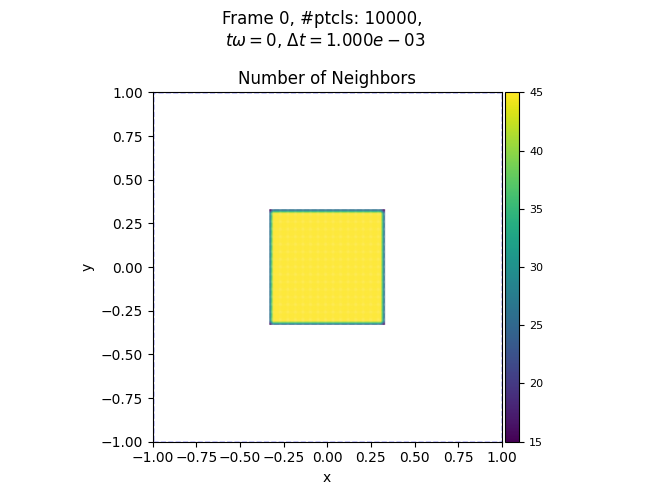

In [7]:
s = 4

fig, axis = plt.subplot_mosaic('''A''', figsize=(6.5,5), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)
# val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
# plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, val , cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
# axis['A'].set_title(r'$P/\rho\omega^2L^2$')

val = perennialState['fluidNumNeighbors']
plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, val , cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
axis['A'].set_title(r'Number of Neighbors')

fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState["numParticles"]}, 
$t\omega = {perennialState["time"] * omega :.3g}$, $\Delta t = {perennialState["dt"]:.3e}$''')

# axis['A'].set_xlim(perennialState['fluidPositions'][:,0].min().cpu().item()*1.1, perennialState['fluidPositions'][:,0].max().cpu().item()*1.1)
# axis['A'].set_ylim(perennialState['fluidPositions'][:,1].min().cpu().item()*1.1, perennialState['fluidPositions'][:,1].max().cpu().item()*1.1)

fig.tight_layout()


In [8]:
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
outFolder = './output/' + timestamp + '/'
os.makedirs(outFolder, exist_ok = True)


while True:
    perennialState, *priorState = integrate(simulationStep, perennialState, config, previousStep= priorState)
    # Particle shifting
    dx, _ = solveShifting(perennialState, config)
    perennialState['fluidPositions'] += dx
    # Frame done, update state for next timestep
    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    perennialState['dt'] = config['timestep']['dt']
    config['timestep']['dt'] = computeTimestep(perennialState, config)
    time = perennialState['time']
    dt = config['timestep']['dt']

    if perennialState['time'] * omega > 10:
        break

    if perennialState["timestep"] % 16 == 1:
        fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState["numParticles"]}, 
$t\omega = {perennialState["time"] * omega :.3g}$, $\Delta t = {perennialState["dt"]:.3e}$''')
        val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
        val = perennialState['fluidNumNeighbors']
        # axis['A'].set_xlim(perennialState['fluidPositions'][:,0].min().cpu().item()*1.1, perennialState['fluidPositions'][:,0].max().cpu().item()*1.1)
        # axis['A'].set_ylim(perennialState['fluidPositions'][:,1].min().cpu().item()*1.1, perennialState['fluidPositions'][:,1].max().cpu().item()*1.1)


        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(plotStateIndex, visualizationState, val)
        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(outFolder + 'frame_{:04d}.png'.format(perennialState["timestep"]), dpi = 300)

In [10]:
import subprocess
import shlex
output = 'squarePatch'
scale = 1280

command = '/usr/bin/ffmpeg -loglevel warning -hide_banner -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r 30 ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps=30,scale={scale}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps=30,scale={scale}:-1:flags=lanczos[x];[x][1:v]paletteuse" {timestamp if output == "timestamp" else output}.gif'

print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
subprocess.run(shlex.split(command))
print('Creating gif palette')
subprocess.run(shlex.split(commandB))
print('Creating gif')
subprocess.run(shlex.split(commandC))
print('Done')

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

CompletedProcess(args=['ffmpeg', '-hide_banner', '-y', '-i', './output/2024_03_06-15_31_28/output.mp4', '-i', './output/2024_03_06-15_31_28/palette.png', '-filter_complex', 'fps=30,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse', 'squarePatch.gif'], returncode=0)

<img src = "./squarePatch.gif" width = 500/>